In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import projection_nullspace, apply_forwardmodel, projection_nullspace_operator
# these need to be tested against analytical values:
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import kersize_samplingYX,feasibleApp_samplingYX_perbatch_cuda,feasibleApp_samplingYX_linear_cuda ,target_distances_samplingYX_precomputedFA_cuda_V2, avgLB_samplingYX
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 200
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 100
input_target_pairs = 200

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

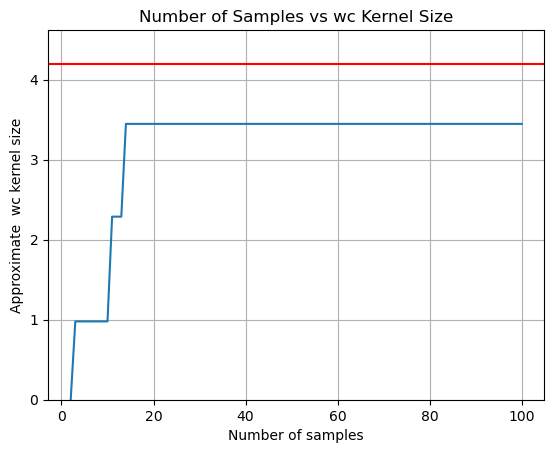

Total Max Kernel Size: 3.447830527028058
Analytical Kernel Size: 4.2
Relative Error: -0.17908796975522437


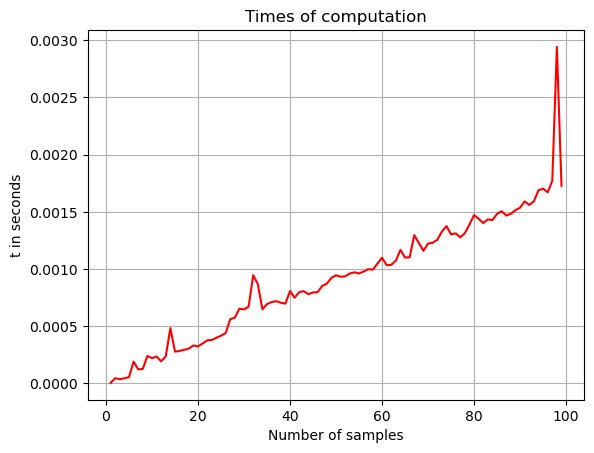

The last kernel size computation took 0.001727 seconds


In [3]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, np.arange(2, max_k+1))

plot_times_comput(list(range(1,max_k,1)), times_comput)


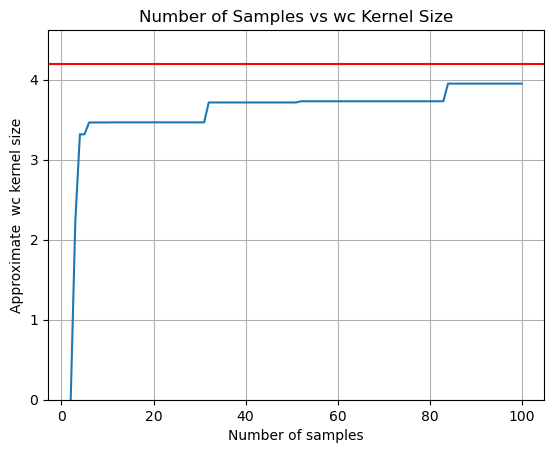

Total Max Kernel Size: 3.9510416906099035
Analytical Kernel Size: 4.2
Relative Error: -0.059275787950023015


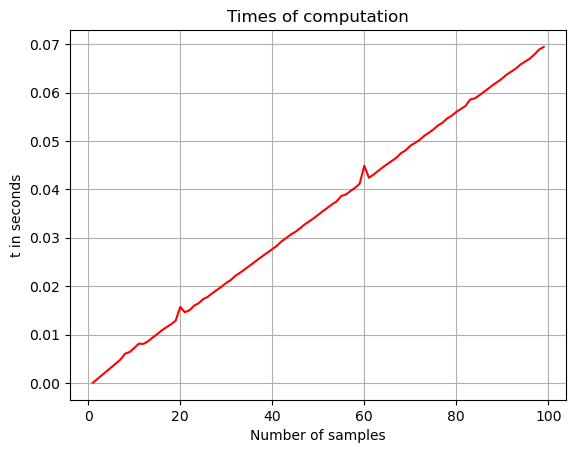

The last kernel size computation took 0.069429 seconds


In [4]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, np.arange(2, max_k+1))
plot_times_comput(list(range(1,max_k,1)), times_comput)

### Worst-case kernel size for linear forward model with additive noise, parallelized

In [5]:
batch_size = 50

input_loader1 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
input_loader2 = DataLoader(input_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader1 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False)
target_loader2 = DataLoader(target_data, batch_size=batch_size, num_workers=batch_size, drop_last=False) 

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


First test the 2 ways of computing feasible appartenance

In [6]:
t0 = time.time()
feas_app_1 = feasibleApp_samplingYX_perbatch_cuda(input_data=input_loader1, forwarded_target= input_loader2, p_Y=2, epsilon=epsilon)
t1 = time.time()
feas_app_2 = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=2, epsilon= epsilon, batchsize=50)
t2 = time.time()

print(f'Per batch : tool {t1-t0:.4f} seconds')
print(f'With candidate selection : {t2-t1:.4f} seconds')


/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:363: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forwarded_target = torch.tensor(forwarded_target, dtype = torch.float32, device = device)
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype = torch.float32, device = device)
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:368: UserWarnin

/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Per batch : tool 686.4158 seconds
With candidate selection : 87.8679 seconds


In [7]:
delta = feas_app_1 - feas_app_2.to(dtype=feas_app_1.dtype)
print(f'Difference between the computations {delta.sum()}')

Difference between the computations 0.0


Then, test the kersize with 1 of the 2 feas app and both target_dists_preomputed FA

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [01:15<10:00, 75.02s/it]

 22%|██▏       | 2/9 [02:19<08:01, 68.82s/it]

 33%|███▎      | 3/9 [03:20<06:31, 65.27s/it]

 44%|████▍     | 4/9 [12:06<20:36, 247.21s/it]

 56%|█████▌    | 5/9 [13:13<12:08, 182.08s/it]

 67%|██████▋   | 6/9 [14:05<06:53, 137.94s/it]

 78%|███████▊  | 7/9 [15:00<03:41, 110.98s/it]

 89%|████████▉ | 8/9 [15:59<01:34, 94.21s/it] 

100%|██████████| 9/9 [16:56<00:00, 112.89s/it]


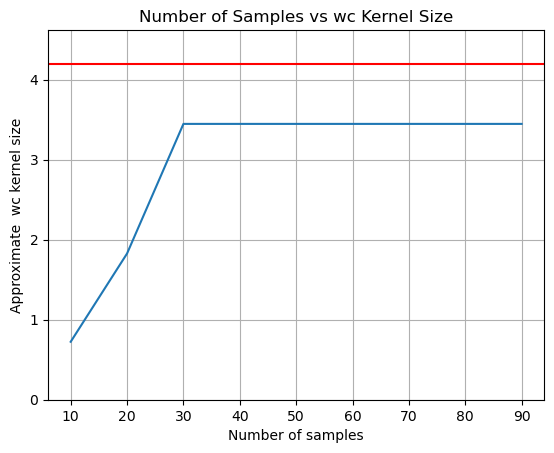

Total Max Kernel Size: 3.447830527028058
Analytical Kernel Size: 4.2
Relative Error: -0.17908796975522437


In [8]:
from tqdm import tqdm
import torch

max_k = 100
batch_size = 50
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

for k in tqdm(range(10,max_k,10)):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasibleApp_samplingYX_linear_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= 2*epsilon, batchsize = k)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX, feasible_appartenance = target_distances_samplingYX_precomputedFA_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize=k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = kersize_samplingYX(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(range(10,max_k,10)))

#print('Feasible appartenance computation times :')
#plot_times_comput(list(range(50,max_k,10)), times_comput_FA)
#print('WC Kersize computation times : ')
#plot_times_comput(list(range(50,max_k,10)), times_comput_WC)




### Average kernel size

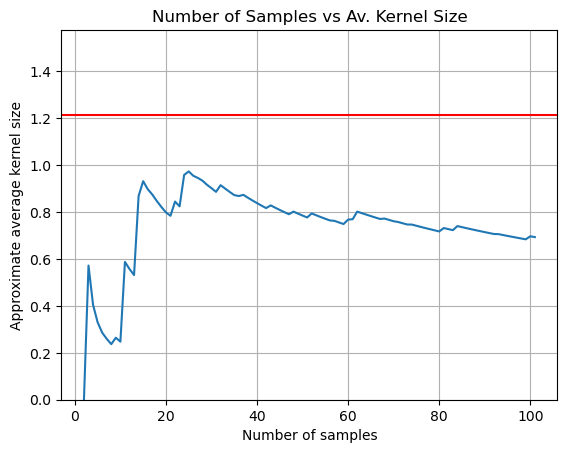

Total Max Kernel Size: 0.6934682882307077
Analytical Kernel Size: 1.2124355652982142
Relative Error: -0.4280369958793313


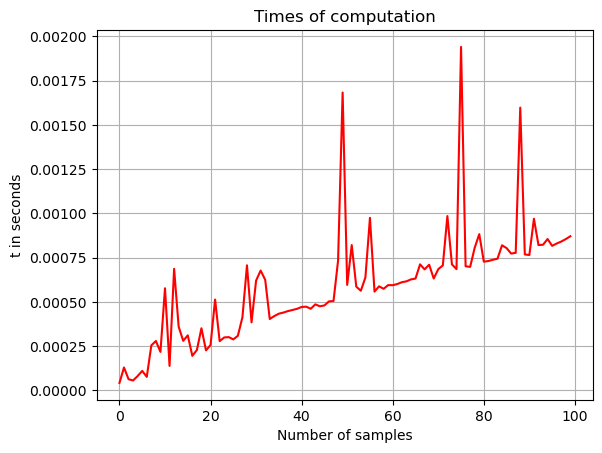

The last kernel size computation took 0.000871 seconds


In [10]:
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)

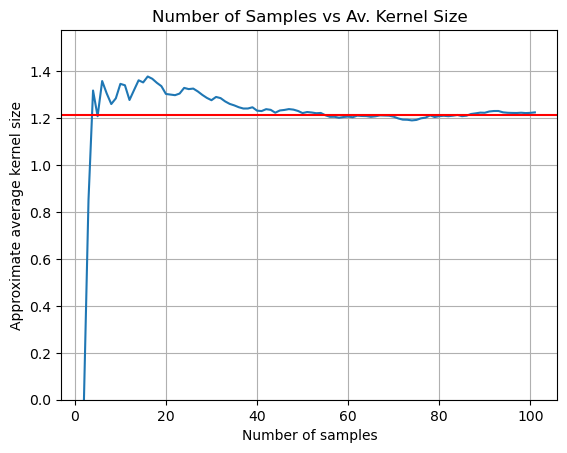

Total Max Kernel Size: 1.2253366743097667
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.010640655372377919


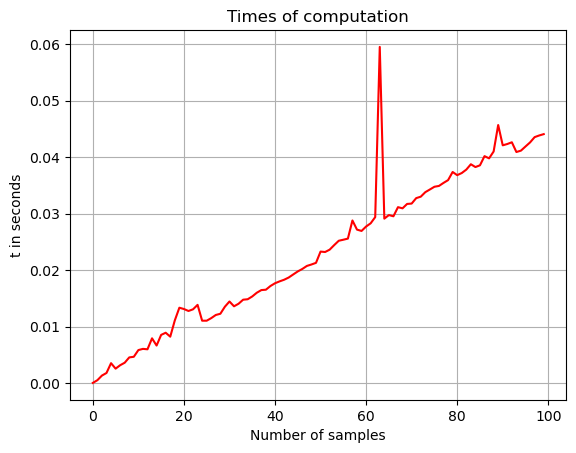

The last kernel size computation took 0.044075 seconds


In [14]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
for k in range(0,max_k):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical, max_k+1)
plot_times_comput(list(range(0,max_k,1)), times_comput)